In [70]:
import numpy as np
import seaborn as sns
import transformation
import significantdigits as sd
from matplotlib import pyplot as plt
from fsl.transform import flirt, affine

import warnings
warnings.filterwarnings('ignore')

In [71]:
#remove all the numbers later 50, 10, 3 etc

In [72]:
path_PD = './outputs_PD/anat-12dofs'
path_HC = './outputs_HC/anat-12dofs'

In [73]:
paths_PD = transformation.get_matrices_paths(path_PD)
paths_HC = transformation.get_matrices_paths(path_HC)

In [74]:
mat_dic_PD = transformation.get_matrices(paths_PD)
mat_dic_HC = transformation.get_matrices(paths_HC)

In [75]:
mean_PD, std_PD = np.zeros((50,4,4)), np.zeros((50,4,4))
mean_HC, std_HC = np.zeros((50,4,4)), np.zeros((50,4,4))

for i,sub in enumerate(mat_dic_PD.keys()):
    mean_PD[i] = np.mean(mat_dic_PD[sub]["mca"], axis=0)
    std_PD[i] = np.std(mat_dic_PD[sub]["mca"], axis=0)

for i,sub in enumerate(mat_dic_HC.keys()):
    mean_HC[i] = np.mean(mat_dic_HC[sub]['mca'], axis=0)
    std_HC[i] = np.std(mat_dic_HC[sub]["mca"], axis=0)


In [76]:
mean_PD[0]

array([[ 1.03657019e+00, -2.16879669e-02,  7.09773111e-02,
        -3.81499894e+00],
       [-1.03338692e-03,  1.07185337e+00,  7.47641274e-02,
        -2.54993864e+00],
       [-6.79830301e-02, -5.52040298e-02,  1.07668213e+00,
        -5.95488795e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [77]:
std_PD[0]

array([[2.34194164e-05, 4.72226021e-04, 1.13435455e-04, 4.40786790e-02],
       [5.26613991e-04, 8.26092187e-05, 1.52723722e-04, 4.87566681e-02],
       [1.49846303e-04, 2.02517635e-04, 1.08858907e-04, 2.70641620e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [78]:
def cell_significant_digit(mat_dic):

    significant_digits_dict = {key:np.zeros((4,4)) for key in mat_dic.keys()}
    for key in mat_dic.keys():
        matrix = mat_dic[key]['mca']
        mean_sub = np.mean(matrix, axis=0)
        for i in range(4):
            for j in range(4):
                significant_digits_dict[key][i,j] = sd.significant_digits(matrix[:,i,j], reference=mean_sub[i,j], basis=10)
    
    return significant_digits_dict

In [79]:
cell_significant_digits_dict_PD = cell_significant_digit(mat_dic_PD)
cell_significant_digits_dict_HC = cell_significant_digit(mat_dic_HC)

In [80]:
cell_significant_digits_PD = np.array(list(cell_significant_digits_dict_PD.values()))
cell_significant_digits_HC = np.array(list(cell_significant_digits_dict_HC.values()))

In [81]:
np.max(cell_significant_digits_PD, axis=0)

array([[ 4.37104303,  2.74516568,  4.06436344,  2.78036936],
       [ 3.72823316,  4.37954739,  3.10545443,  3.19706534],
       [ 2.76841606,  3.46591067,  3.72546666,  2.89121485],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [82]:
np.max(cell_significant_digits_HC, axis=0)

array([[ 4.45679749,  2.63711068,  2.64076903,  2.78584956],
       [ 2.9440517 ,  4.51318849,  3.00676552,  3.09448483],
       [ 2.7079212 ,  3.19049237,  4.04447148,  3.11014282],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [83]:
np.mean(cell_significant_digits_PD, axis=0)

array([[ 3.4644545 ,  1.37350673,  1.49718741,  1.6203995 ],
       [ 1.28983991,  3.42226385,  2.08675437,  2.05864231],
       [ 1.20075036,  2.32388483,  2.87418416,  2.07811176],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [84]:
np.mean(cell_significant_digits_HC, axis=0)

array([[ 3.78539466,  1.26976946,  1.21905954,  1.48139317],
       [ 1.33051513,  3.61392229,  2.14935121,  2.18077753],
       [ 1.15344231,  2.22925417,  3.21376706,  2.25939095],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [85]:
np.min(cell_significant_digits_PD, axis=0)

array([[-0.42819398, -0.58785109, -1.25113768, -0.85836331],
       [-1.13662462, -0.43864345, -0.15676659, -2.52290452],
       [-0.5692634 , -0.06183924, -0.14642001, -0.31383016],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [86]:
np.min(cell_significant_digits_HC, axis=0)

array([[ 2.55292504, -1.28592239, -0.89943436, -0.25056002],
       [-0.38430498,  2.74445647,  0.2335309 ,  0.38246343],
       [-0.50976588,  0.10328191,  2.4985375 ,  0.98636508],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

Text(0.5, 1.0, 'MCA means for each cell _PD subjects_')

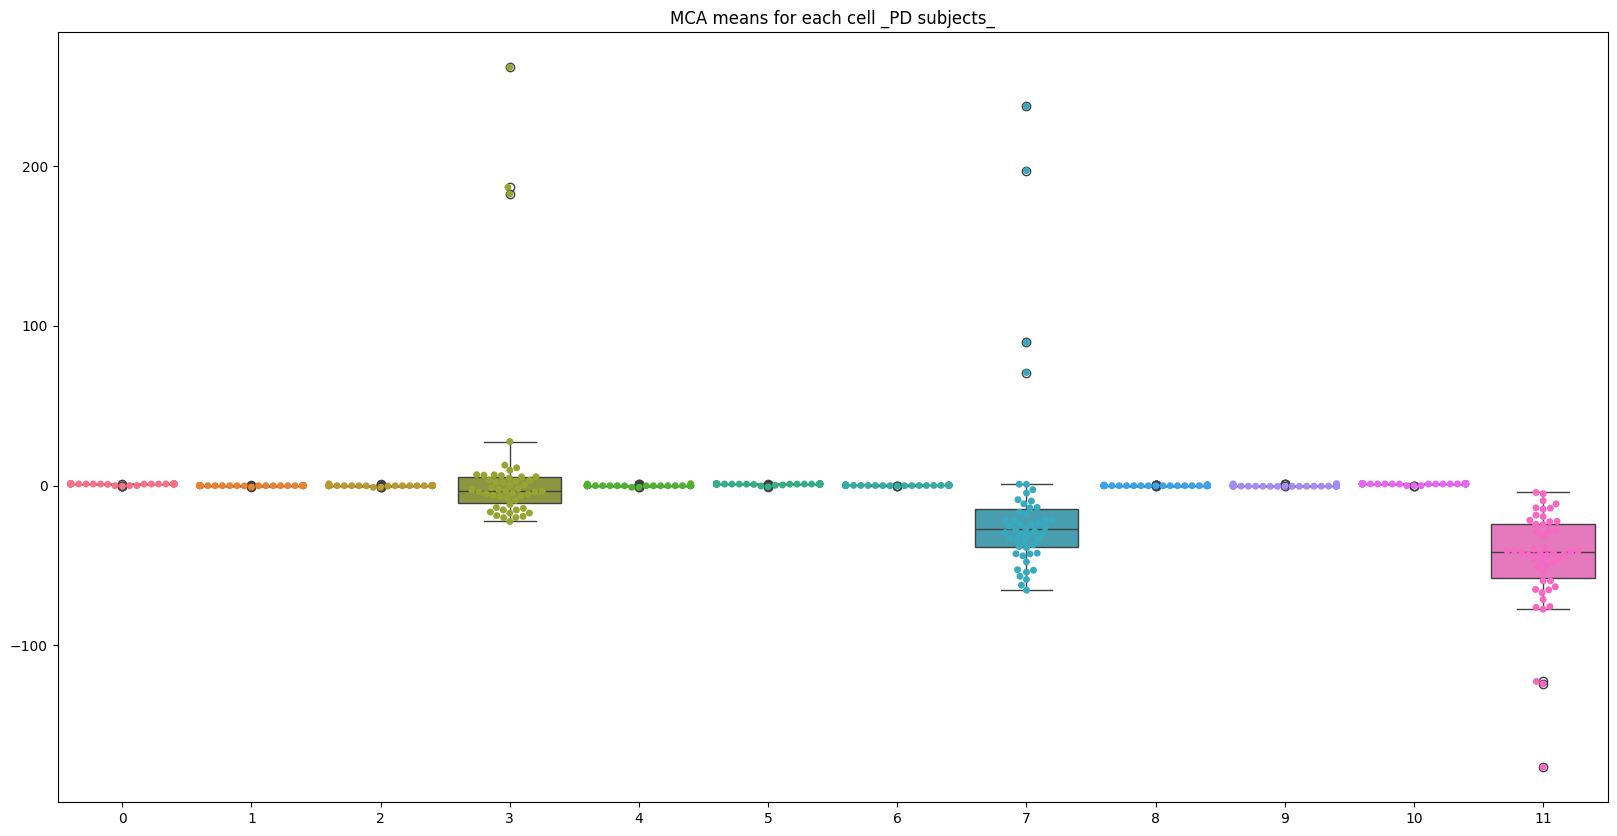

In [87]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(mean_PD[:,:3,:].reshape(50,12))
_ = sns.boxplot(mean_PD[:,:3,:].reshape(50,12))
plt.title('MCA means for each cell _PD subjects_')

Text(0.5, 1.0, 'MCA SD for each cell _PD subjects_')

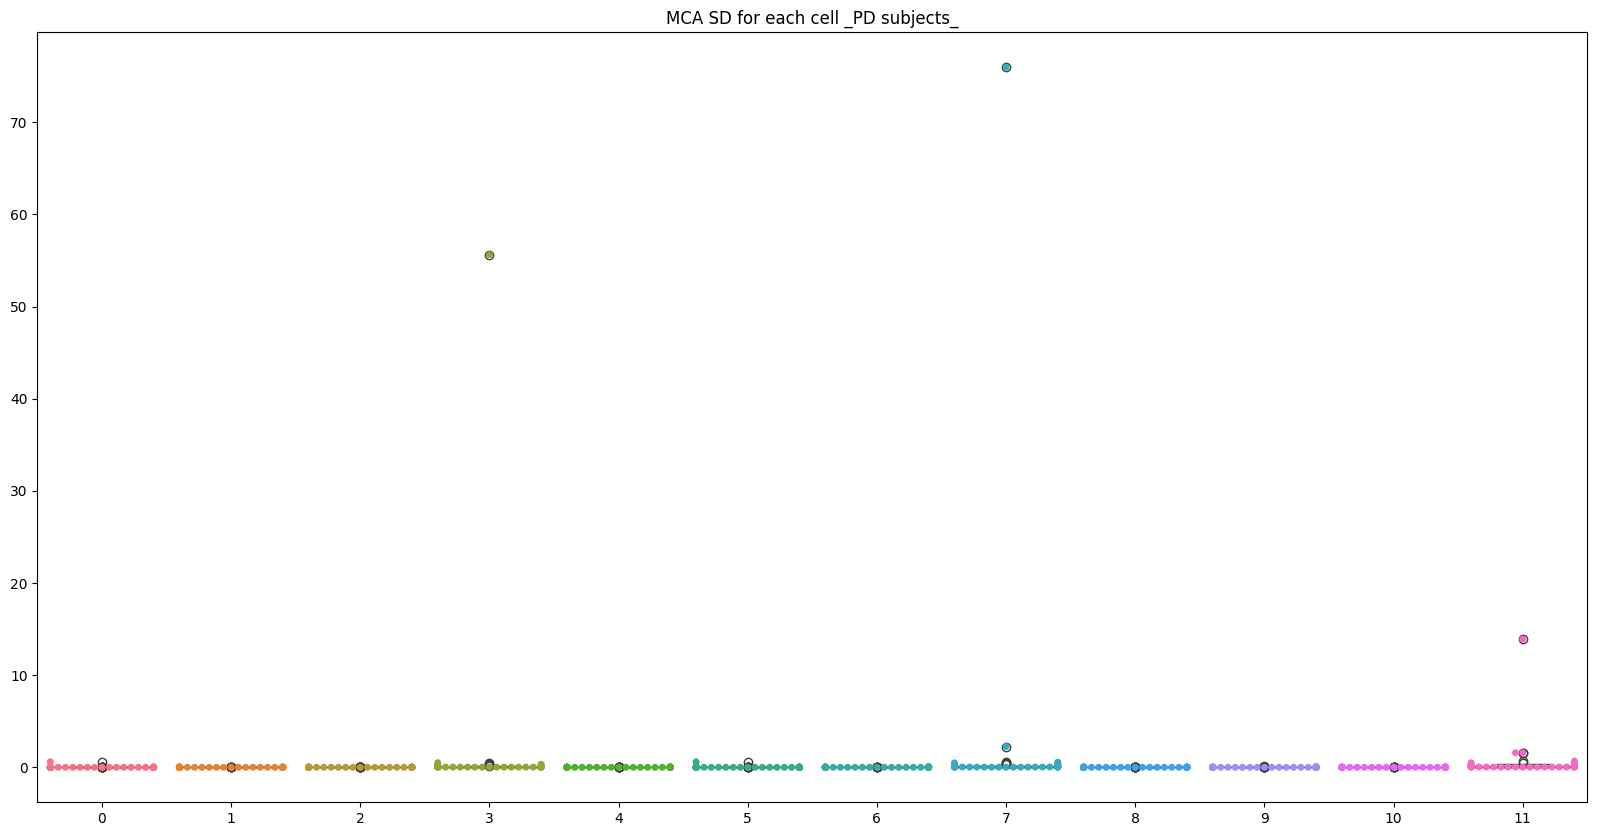

In [88]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(std_PD[:,:3,:].reshape(50,12))
_ = sns.boxplot(std_PD[:,:3,:].reshape(50,12))
plt.title('MCA SD for each cell _PD subjects_')

Text(0.5, 1.0, 'MCA means for each cell _HC subjects_')

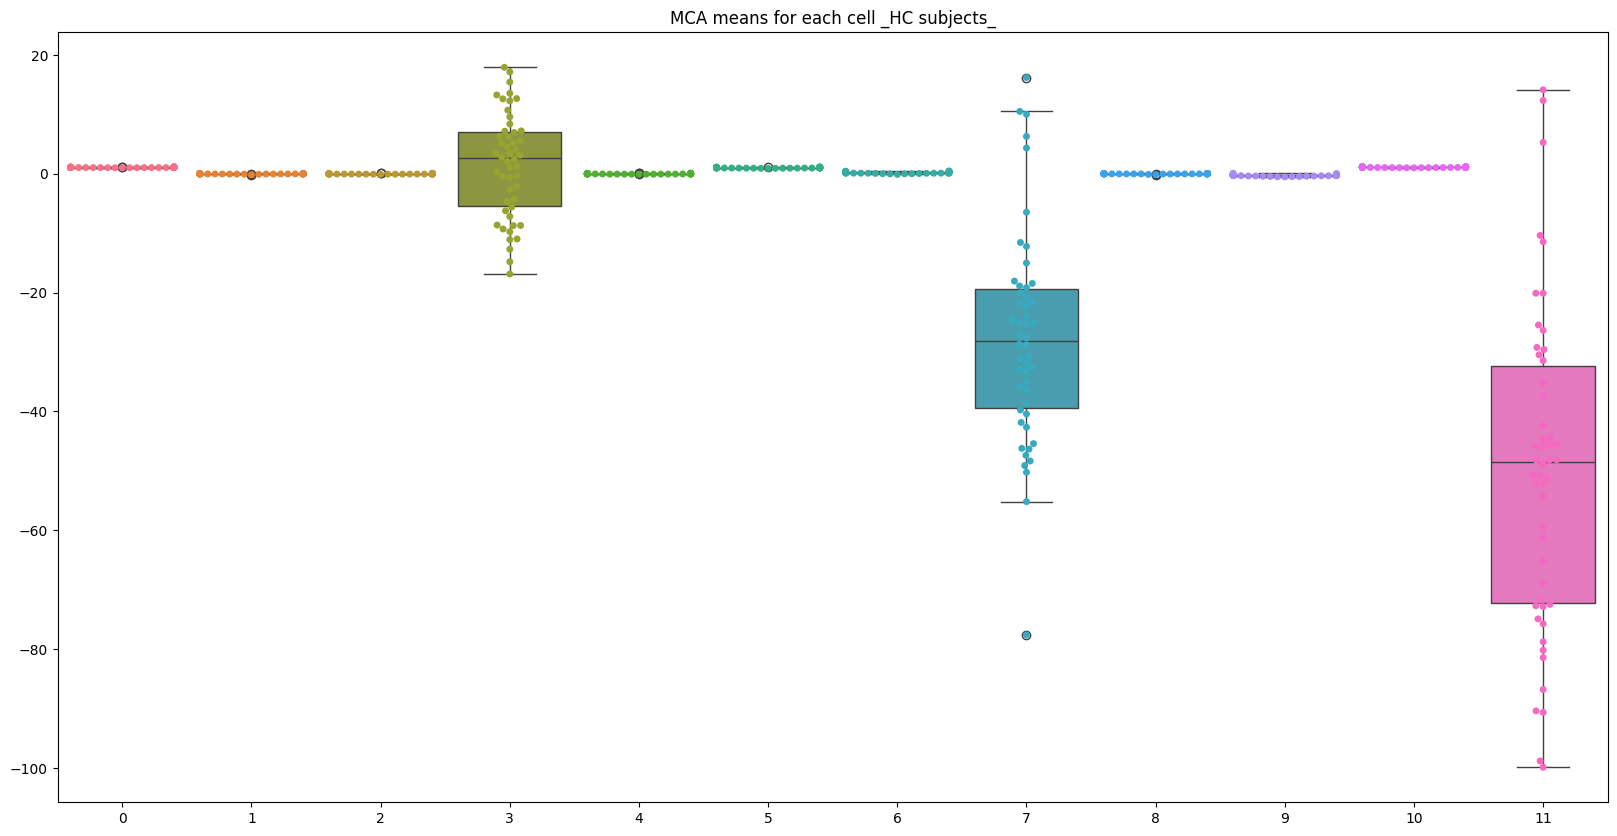

In [89]:
plt.figure(figsize=(20,10))
sns.swarmplot(mean_HC[:,:3,:].reshape(50,12))
sns.boxplot(mean_HC[:,:3,:].reshape(50,12))
plt.title('MCA means for each cell _HC subjects_')

Text(0.5, 1.0, 'MCA sds for each cell _HC subjects_')

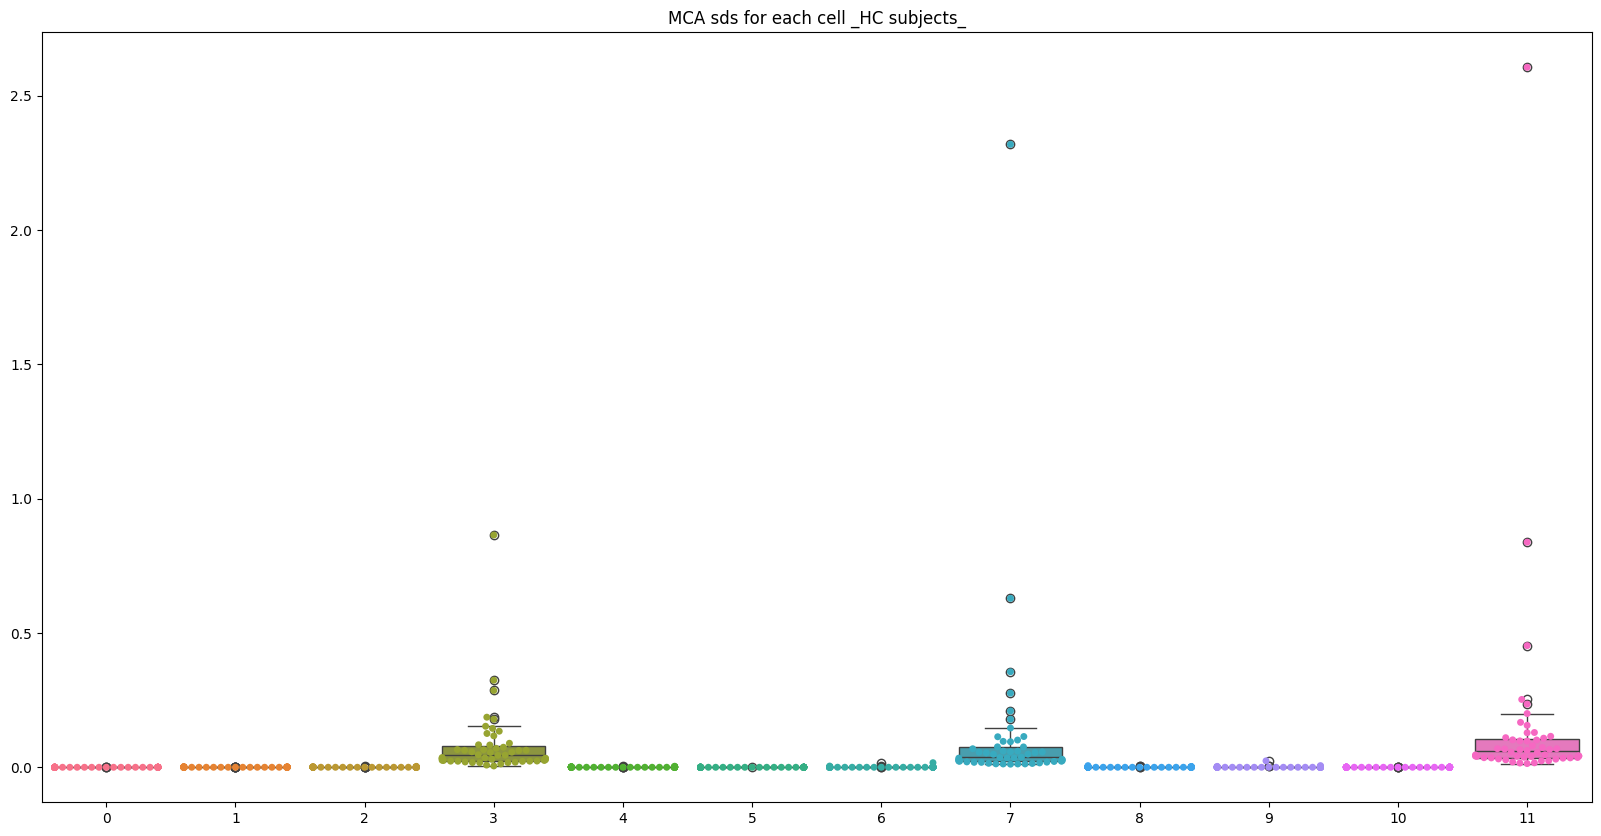

In [90]:
plt.figure(figsize=(20,10))
sns.swarmplot(std_HC[:,:3,:].reshape(50,12))
sns.boxplot(std_HC[:,:3,:].reshape(50,12))
plt.title('MCA sds for each cell _HC subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _PD subjects_')

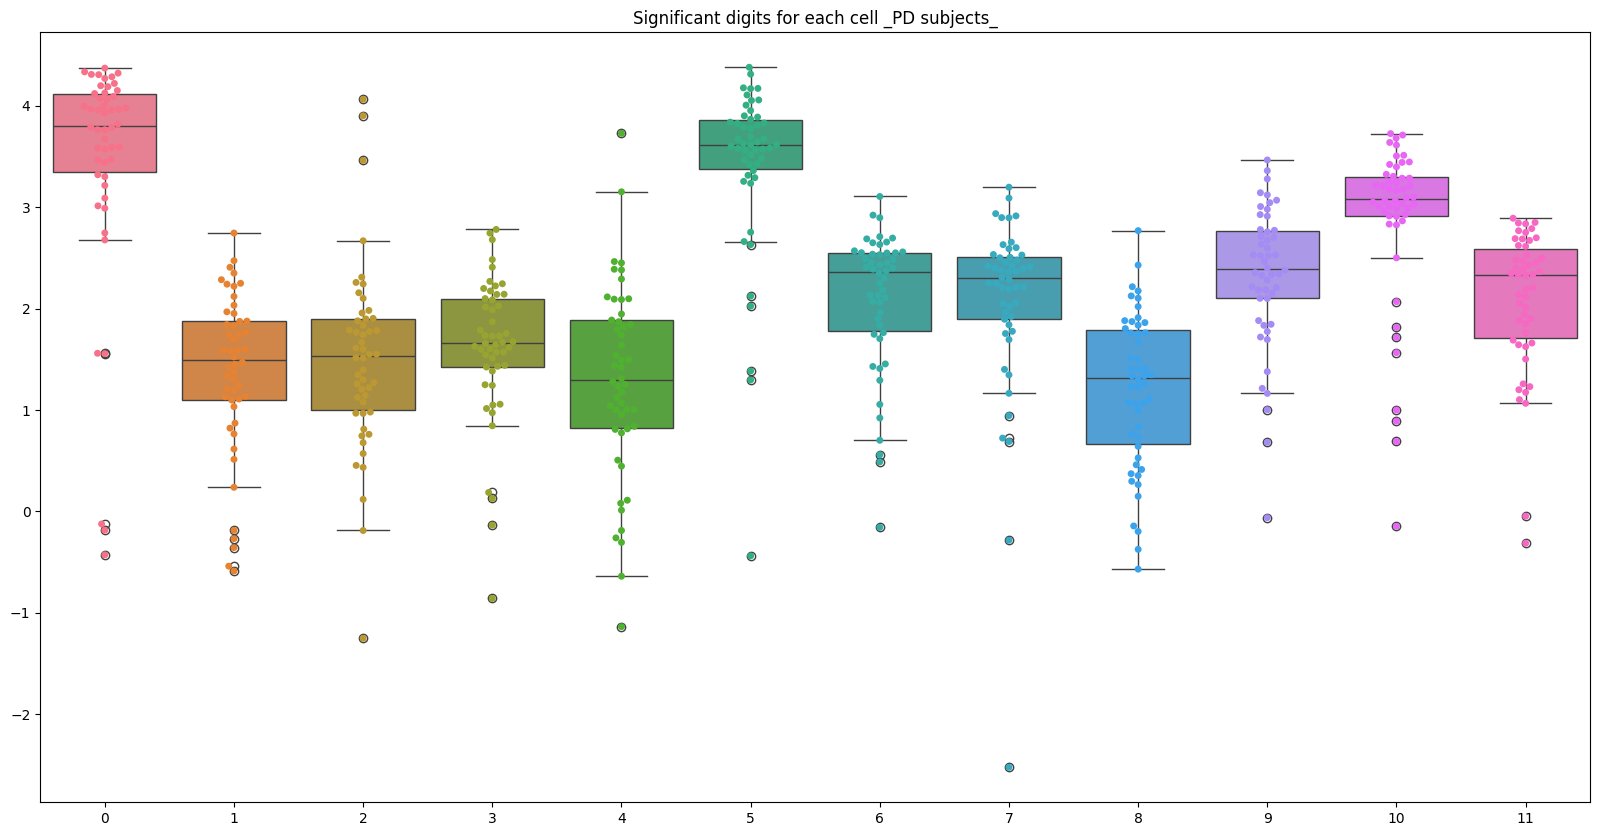

In [91]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_PD[:,:3,:].reshape(50,12))
sns.boxplot(cell_significant_digits_PD[:,:3,:].reshape(50,12))
plt.title('Significant digits for each cell _PD subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _HC subjects_')

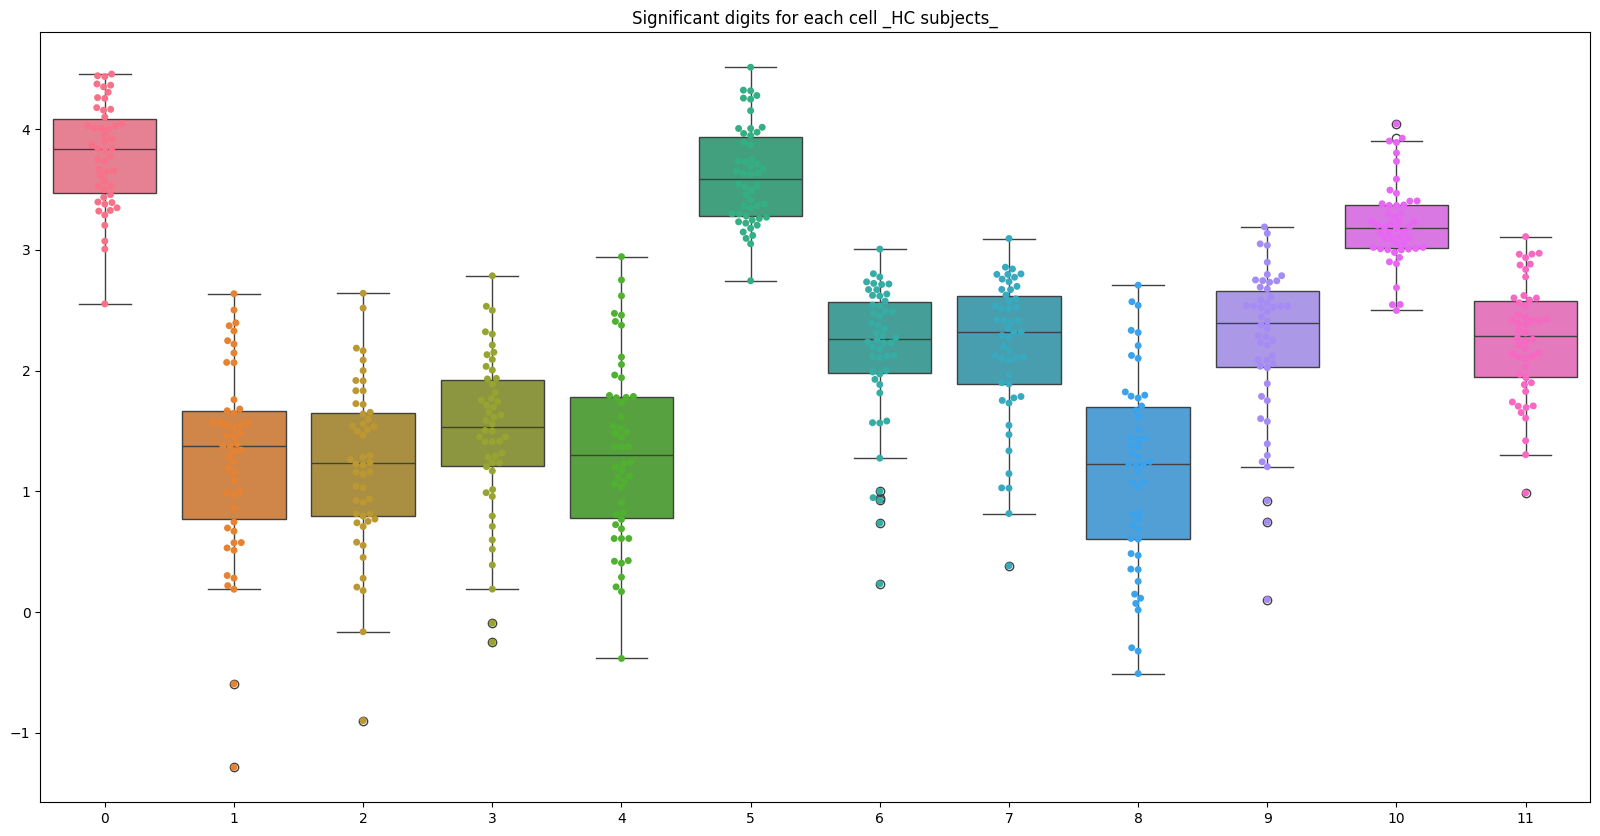

In [92]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_HC[:,:3,:].reshape(50,12))
sns.boxplot(cell_significant_digits_HC[:,:3,:].reshape(50,12))
plt.title('Significant digits for each cell _HC subjects_')

In [93]:
scales, translation, rotation, shears = affine.decompose(mat_dic_PD['sub-3001_ses-BL']['ieee'], shears=True, angles=True)

In [94]:
def transformation_dictionaries(mat_dic):

    scales_mca_dict = {sub:np.zeros((10, 3)) for sub in mat_dic.keys()}
    translation_mca_dict = {sub:np.zeros((10, 3)) for sub in mat_dic.keys()}
    angels_mca_dict = {sub:np.zeros((10, 3)) for sub in mat_dic.keys()}
    shears_mca_dict = {sub:np.zeros((10, 3)) for sub in mat_dic.keys()}

    for sub in mat_dic.keys():
        for (i,matrix) in enumerate(mat_dic[sub]['mca']):
            scales, translations, angels, shears = affine.decompose(matrix, shears=True, angles=True)
            scales_mca_dict[sub][i] = scales
            translation_mca_dict[sub][i] = translations
            angels_mca_dict[sub][i] = np.array(angels)
            shears_mca_dict[sub][i] = shears
    return scales_mca_dict, translation_mca_dict, angels_mca_dict, shears_mca_dict

In [112]:
scales_mca_dict_PD, translation_mca_dict_PD, angles_mca_dict_PD, shears_mca_dict_PD = transformation_dictionaries(mat_dic_PD)

In [113]:
scales_mca_dict_HC, translation_mca_dict_HC, angles_mca_dict_HC, shears_mca_dict_HC = transformation_dictionaries(mat_dic_HC)

In [97]:
scales_mca_PD = np.stack([value for value in scales_mca_dict_PD.values()])
scales_mca_HC = np.stack([value for value in scales_mca_dict_HC.values()])

In [99]:
scales_significant_PD = np.stack([sd.significant_digits(scales_mca_PD[i,:,:], reference=np.mean(scales_mca_PD[i,:,:]), axis=0) for i in range(50)])
scales_significant_HC = np.stack([sd.significant_digits(scales_mca_HC[i,:,:], reference=np.mean(scales_mca_HC[i,:,:]), axis=0) for i in range(50)])

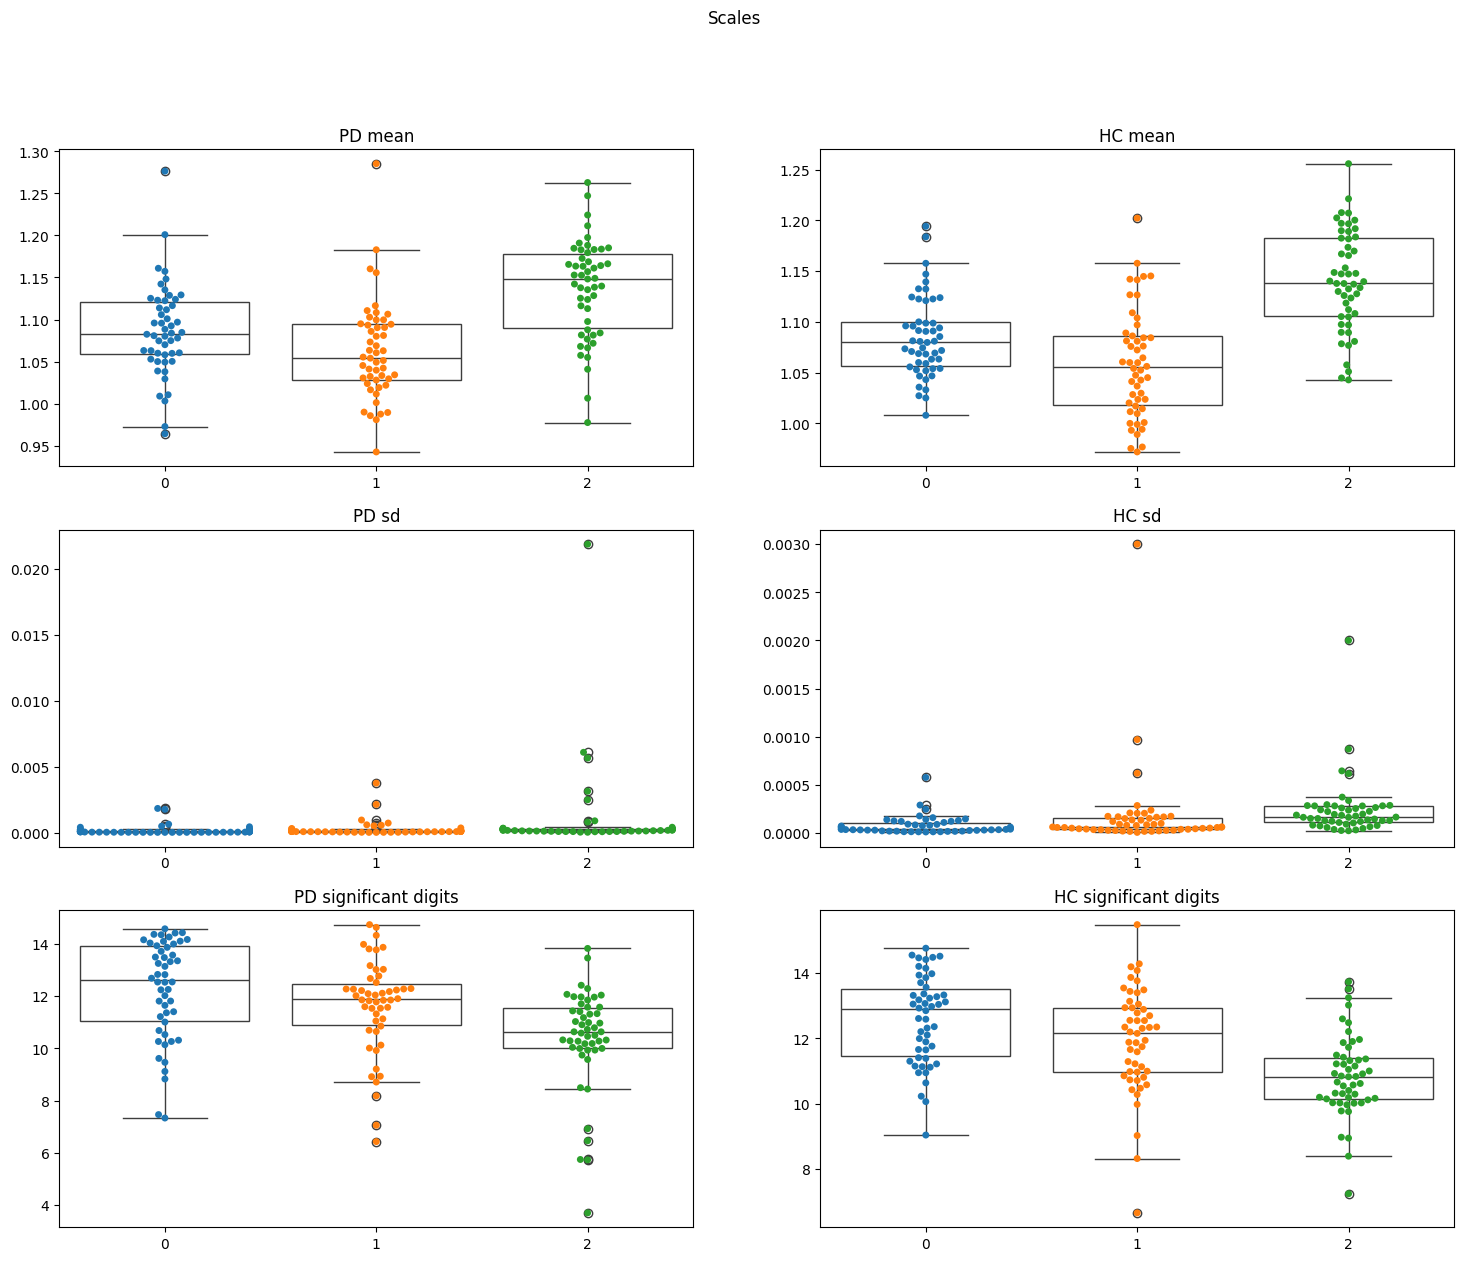

In [121]:
fig = plt.figure(figsize=(18,14))
fig.suptitle('Scales')
plt.subplot(3, 2, 1)
sns.swarmplot(np.mean(scales_mca_PD, axis=1))
sns.boxplot(np.mean(scales_mca_PD, axis=1),color='white')
plt.title('PD mean')
plt.subplot(3, 2, 2)
sns.swarmplot(np.mean(scales_mca_HC, axis=1))
sns.boxplot(np.mean(scales_mca_HC, axis=1),color='white')
plt.title('HC mean')
plt.subplot(3, 2, 3)
sns.swarmplot(np.std(scales_mca_PD, axis=1))
sns.boxplot(np.std(scales_mca_PD, axis=1),color='white')
plt.title('PD sd')
plt.subplot(3, 2, 4)
sns.swarmplot(np.std(scales_mca_HC, axis=1))
sns.boxplot(np.std(scales_mca_HC, axis=1),color='white')
plt.title('HC sd')
plt.subplot(3, 2, 5)
sns.swarmplot(scales_significant_PD)
sns.boxplot(scales_significant_PD, color='white')
plt.title('PD significant digits')
plt.subplot(3, 2, 6)
sns.swarmplot(scales_significant_HC)
sns.boxplot(scales_significant_HC, color='white')
plt.title('HC significant digits')
plt.show()


In [102]:
translations_mca_PD = np.stack([value for value in translation_mca_dict_PD.values()])
translations_mca_HC = np.stack([value for value in translation_mca_dict_HC.values()])

In [106]:
translations_significant_PD = np.stack([sd.significant_digits(translations_mca_PD[i,:,:], reference=np.mean(translations_mca_PD[i,:,:]), axis=0) for i in range(50)])
translations_significant_HC = np.stack([sd.significant_digits(translations_mca_HC[i,:,:], reference=np.mean(translations_mca_HC[i,:,:]), axis=0) for i in range(50)])

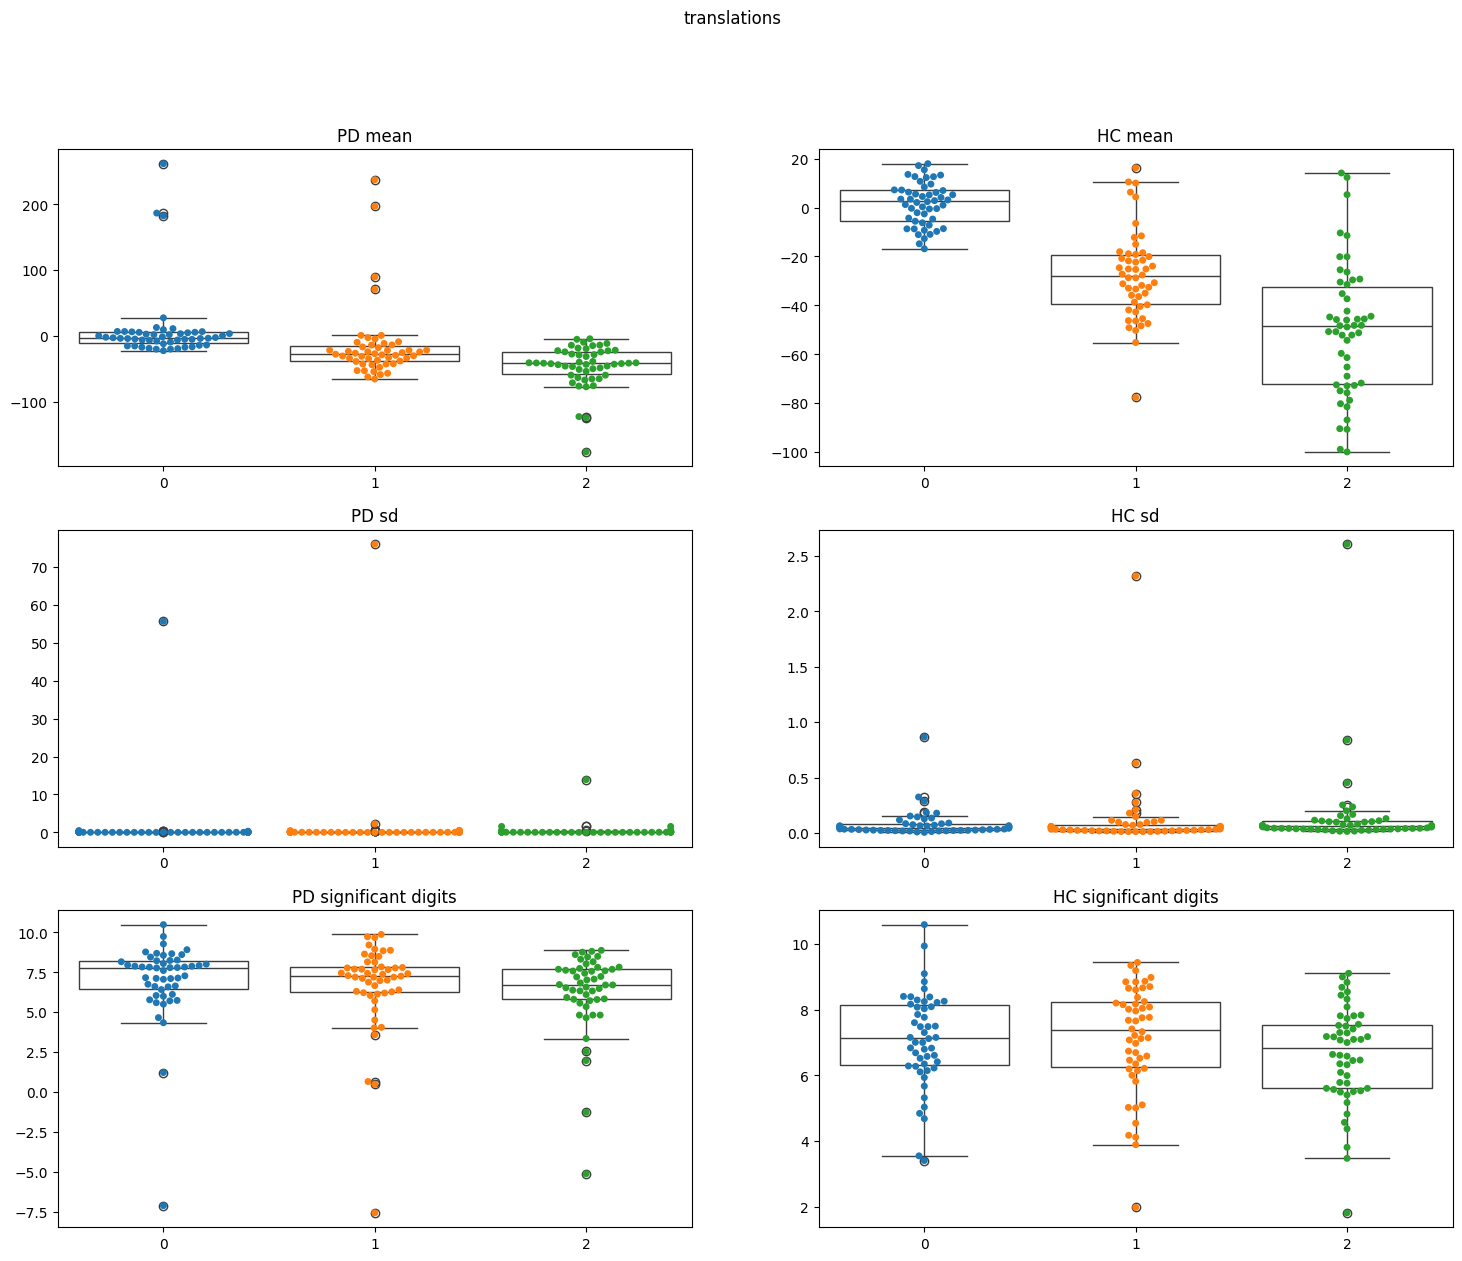

In [124]:
fig = plt.figure(figsize=(18,14))
fig.suptitle('translations')
plt.subplot(3, 2, 1)
sns.swarmplot(np.mean(translations_mca_PD, axis=1))
sns.boxplot(np.mean(translations_mca_PD, axis=1),color='white')
plt.title('PD mean')
plt.subplot(3, 2, 2)
sns.swarmplot(np.mean(translations_mca_HC, axis=1))
sns.boxplot(np.mean(translations_mca_HC, axis=1),color='white')
plt.title('HC mean')
plt.subplot(3, 2, 3)
sns.swarmplot(np.std(translations_mca_PD, axis=1))
sns.boxplot(np.std(translations_mca_PD, axis=1),color='white')
plt.title('PD sd')
plt.subplot(3, 2, 4)
sns.swarmplot(np.std(translations_mca_HC, axis=1))
sns.boxplot(np.std(translations_mca_HC, axis=1),color='white')
plt.title('HC sd')
plt.subplot(3, 2, 5)
sns.swarmplot(translations_significant_PD)
sns.boxplot(translations_significant_PD, color='white')
plt.title('PD significant digits')
plt.subplot(3, 2, 6)
sns.swarmplot(translations_significant_HC)
sns.boxplot(translations_significant_HC, color='white')
plt.title('HC significant digits')
plt.show()


In [105]:
shears_mca_PD = np.stack([value for value in shears_mca_dict_PD.values()])
shears_mca_HC = np.stack([value for value in shears_mca_dict_HC.values()])

In [108]:
shears_significant_PD = np.stack([sd.significant_digits(shears_mca_PD[i,:,:], reference=np.mean(shears_mca_PD[i,:,:]), axis=0) for i in range(50)])
shears_significant_HC = np.stack([sd.significant_digits(shears_mca_HC[i,:,:], reference=np.mean(shears_mca_HC[i,:,:]), axis=0) for i in range(50)])

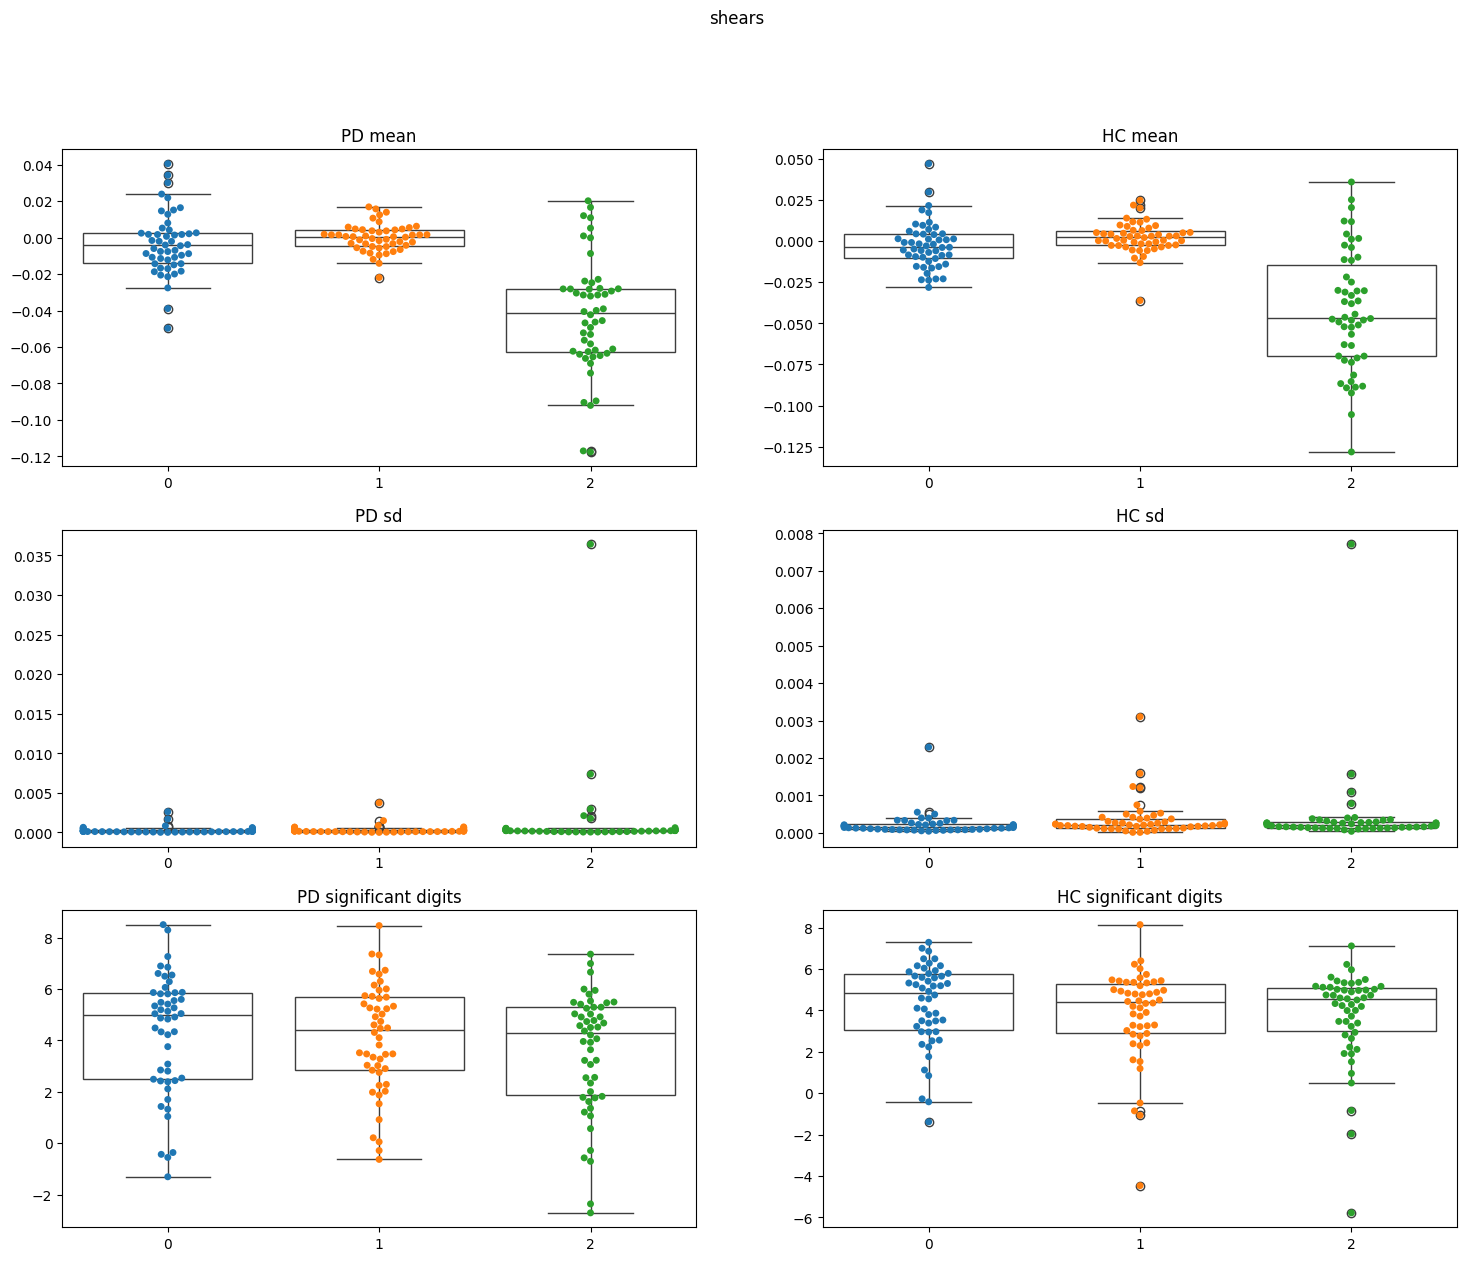

In [127]:
fig = plt.figure(figsize=(18,14))
fig.suptitle('shears')
plt.subplot(3, 2, 1)
sns.swarmplot(np.mean(shears_mca_PD, axis=1))
sns.boxplot(np.mean(shears_mca_PD, axis=1),color='white')
plt.title('PD mean')
plt.subplot(3, 2, 2)
sns.swarmplot(np.mean(shears_mca_HC, axis=1))
sns.boxplot(np.mean(shears_mca_HC, axis=1),color='white')
plt.title('HC mean')
plt.subplot(3, 2, 3)
sns.swarmplot(np.std(shears_mca_PD, axis=1))
sns.boxplot(np.std(shears_mca_PD, axis=1),color='white')
plt.title('PD sd')
plt.subplot(3, 2, 4)
sns.swarmplot(np.std(shears_mca_HC, axis=1))
sns.boxplot(np.std(shears_mca_HC, axis=1),color='white')
plt.title('HC sd')
plt.subplot(3, 2, 5)
sns.swarmplot(shears_significant_PD)
sns.boxplot(shears_significant_PD, color='white')
plt.title('PD significant digits')
plt.subplot(3, 2, 6)
sns.swarmplot(shears_significant_HC)
sns.boxplot(shears_significant_HC, color='white')
plt.title('HC significant digits')
plt.show()


In [114]:
angles_mca_PD = np.degrees(np.stack([value for value in angles_mca_dict_PD.values()]))
angles_mca_HC = np.degrees(np.stack([value for value in angles_mca_dict_HC.values()]))

In [116]:
angles_significant_PD = np.stack([sd.significant_digits(angles_mca_PD[i,:,:], reference=np.mean(angles_mca_PD[i,:,:]), axis=0) for i in range(50)])
angles_significant_HC = np.stack([sd.significant_digits(angles_mca_HC[i,:,:], reference=np.mean(angles_mca_HC[i,:,:]), axis=0) for i in range(50)])

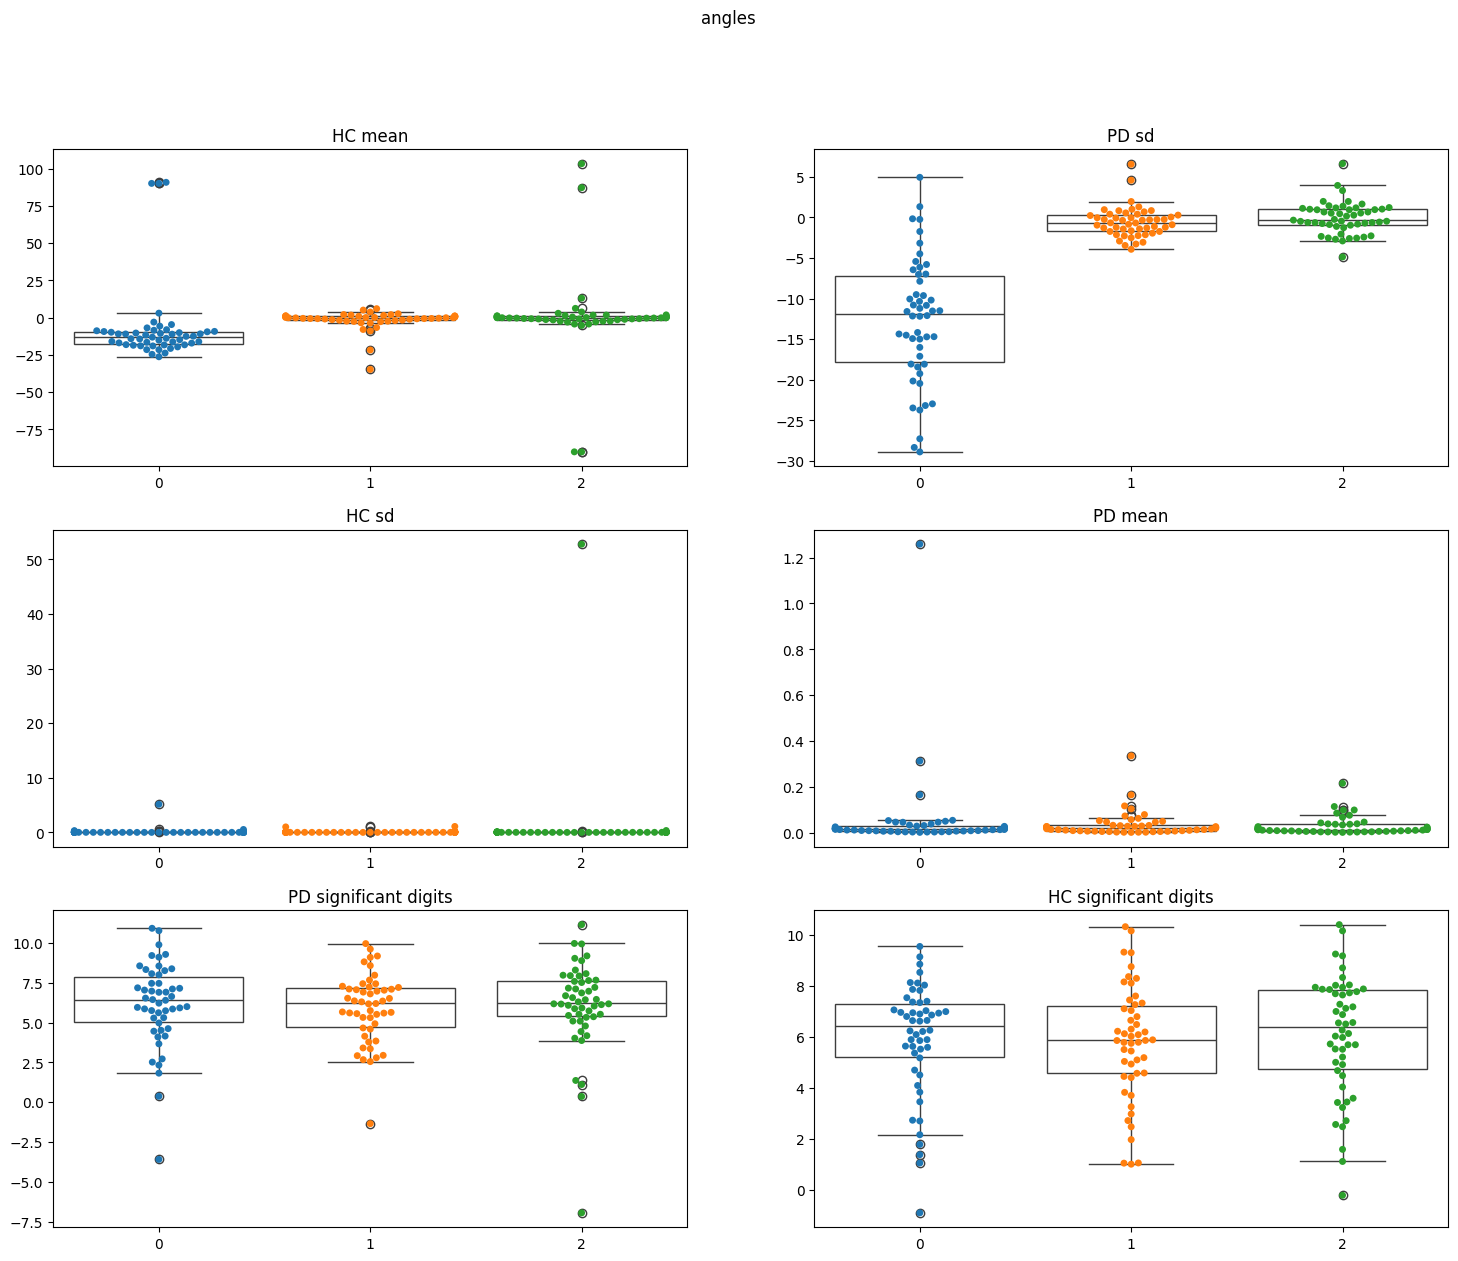

In [129]:
fig = plt.figure(figsize=(18,14))
fig.suptitle('angles')
plt.subplot(3, 2, 1)
sns.swarmplot(np.mean(angles_mca_PD, axis=1))
sns.boxplot(np.mean(angles_mca_PD, axis=1),color='white')
plt.title('HC mean')
plt.subplot(3, 2, 2)
sns.swarmplot(np.mean(angles_mca_HC, axis=1))
sns.boxplot(np.mean(angles_mca_HC, axis=1),color='white')
plt.title('PD sd')
plt.subplot(3, 2, 3)
sns.swarmplot(np.std(angles_mca_PD, axis=1))
sns.boxplot(np.std(angles_mca_PD, axis=1),color='white')
plt.title('HC sd')
plt.subplot(3, 2, 4)
sns.swarmplot(np.std(angles_mca_HC, axis=1))
sns.boxplot(np.std(angles_mca_HC, axis=1),color='white')
plt.title('PD mean')
plt.subplot(3, 2, 5)
sns.swarmplot(angles_significant_PD)
sns.boxplot(angles_significant_PD, color='white')
plt.title('PD significant digits')
plt.subplot(3, 2, 6)
sns.swarmplot(angles_significant_HC)
sns.boxplot(angles_significant_HC, color='white')
plt.title('HC significant digits')
plt.show()
